# **PyLASP** - The Python Version of the LAMOST Stellar Parameter Pipeline

**Welcome!** This tutorial demonstrates how to use PyLASP for:

🔮 **Generating stellar spectra** from input effective temperature ($T_{\rm eff}$), surface gravity (log $g$), metallicity ([Fe/H])<br>
🎯 **Inferring radial velocity (RV), $T_{\rm eff}$, log $g$, [Fe/H]** from LAMOST low-resolution spectra

## Table of contents

1. Setup and imports
2. Use case 1: Generating stellar spectra
3. Use case 2: Parameter inference with LASP-CurveFit
4. Use case 3: GPU-accelerated batch inference with LASP-Adam-GPU

---

## Prerequisites

- Python 3.9+
- PyTorch with CUDA support (recommended for use case 3)
- PyLASP and dependencies
- LAMOST low-resolution spectral data in FITS format

---

## 1. Setup and imports

Configure the computational environment and import required libraries.

In [1]:
import numpy as np
import pandas as pd
import torch
from astropy.io import fits
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from filelock import FileLock
import os, sys

# PyLASP modules
from uly_read_lms.uly_spect_read_lms import uly_spect_read_lms
from uly_fit.ulyss import ulyss
from uly_fit.uly_fit_conv_poly_pytorch import uly_fit_conv_poly
from uly_tgm_eval.uly_tgm_eval_pytorch import uly_tgm_eval
from data_to_pt.data_to_pt import data_to_pt
from file_paths import TGM_MODEL_FILE, TEST_DATA_DIR
from config.config import default_set, set_all_seeds

# Initialize environment
set_all_seeds()
dtype, device = default_set()
torch.set_default_dtype(dtype)
env = os.environ.get('CONDA_DEFAULT_ENV', 'system')

print(f"{env} | {device} | {dtype}")
print(f"Python {sys.version.split()[0]} | NumPy {np.__version__} | Pandas {pd.__version__} | PyTorch {torch.__version__}")
print(f"Astropy {sys.modules['astropy'].__version__} | Matplotlib {sys.modules['matplotlib'].__version__}")
print(f"Joblib {sys.modules['joblib'].__version__} | tqdm {sys.modules['tqdm'].__version__} | FileLock {sys.modules['filelock'].__version__}")
print("✓ Environment initialized successfully")

PyLASP-env | cuda | torch.float32
Python 3.10.19 | NumPy 1.26.4 | Pandas 2.2.3 | PyTorch 2.5.0+cu121
Astropy 6.0.1 | Matplotlib 3.9.4
Joblib 1.4.2 | tqdm 4.67.1 | FileLock 3.18.0
✓ Environment initialized successfully


---

## 2. Use case 1: Generating stellar spectra

This section demonstrates how to generate stellar spectra from $T_{\rm eff}$, log $g$, [Fe/H] using the spectral emulator.

### 2.1 Load spectral emulator coefficients

At each wavelength, the model flux is approximated by a 23-term multivariate polynomial function of $T_{\rm eff}$, log $g$, [Fe/H].

In [2]:
# Load TGM spectral emulator coefficients from FITS file
hdul = fits.open(TGM_MODEL_FILE())

# Extract header and data extensions
# The model uses three temperature regimes for optimal accuracy:
#   - Extension 0: Warm stars (Primary)
#   - Extension 1: Hot stars (hot)
#   - Extension 2: Cool stars (cold)
hdr = hdul[0].header
warm_coeffs = hdul[0].data
hot_coeffs = hdul[1].data
cold_coeffs = hdul[2].data

# Stack temperature regimes and convert to PyTorch tensor
spec_coef = torch.tensor(
    np.nan_to_num(np.stack([warm_coeffs, hot_coeffs, cold_coeffs], axis=-1)),
    dtype=dtype,
    device=device
)[:23, :, :]

# Reconstruct wavelength array (3900-6800 Å, 0.2 Å/pixel, air wavelength)
wave = hdr["CRVAL1"] + np.arange(hdr["NAXIS1"]) * hdr["CDELT1"]

# Display emulator properties
print(f"TGM spectral emulator loaded successfully")
print(f"  Coefficient tensor shape: {spec_coef.shape}")
print(f"  Wavelength coverage: {wave[0]:.2f} - {wave[-1]:.2f} Å")
print(f"  Number of pixels: {hdr['NAXIS1']}")

TGM spectral emulator loaded successfully
  Coefficient tensor shape: torch.Size([23, 14501, 3])
  Wavelength coverage: 3900.00 - 6800.00 Å
  Number of pixels: 14501


### 2.2 Generate example spectra

Generate two example spectra with different stellar parameters:

| Spectrum | $T_{\rm eff}$ (K) | log $g$ (dex) | [Fe/H] (dex) |
|----------|-------------------|---------------|--------------|
| 1        | 5000              | 3.0           | 0.0          |
| 2        | 7500              | 4.0           | +0.5         |

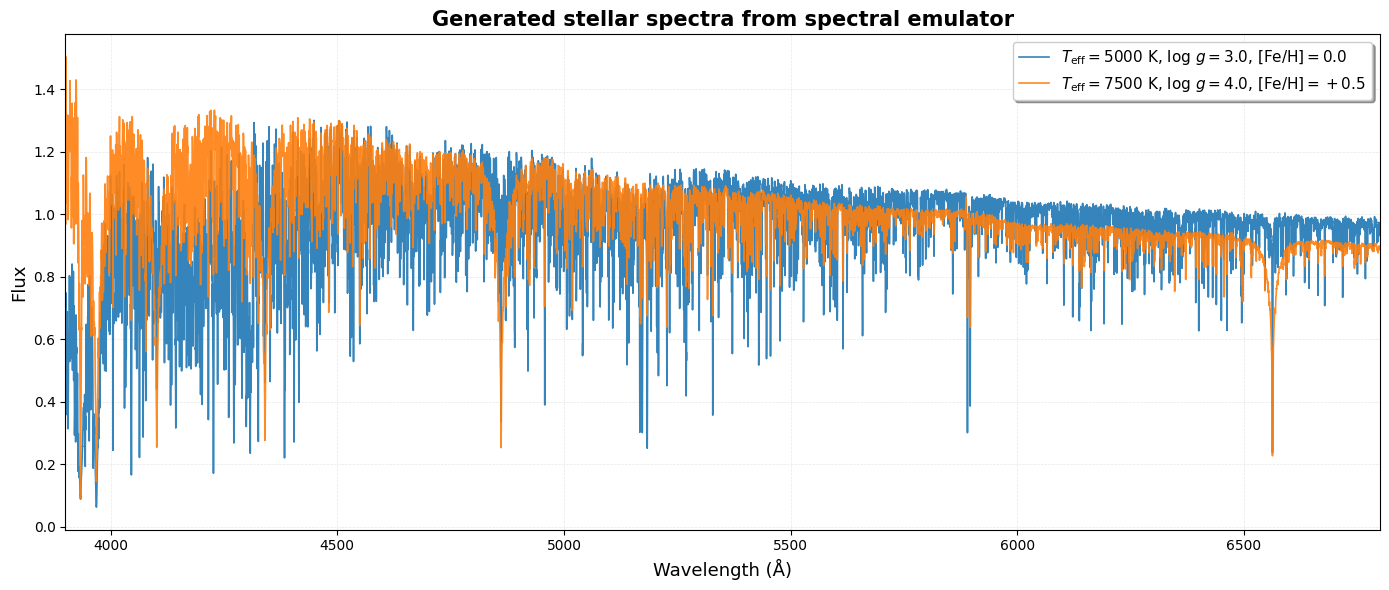


✓ Successfully generated 2 stellar spectra
  Wavelength range: 3900.0 - 6800.0 Å


In [3]:
# Define atmospheric parameters in physical units
params_physical = np.array([
    [5000.0, 3.0, 0.0],
    [7500.0, 4.0, 0.5]
])

# Scale parameters for emulator input
params_normalized = torch.tensor(
    [
        [np.log10(params_physical[0, 0]) - 3.7617, 
         params_physical[0, 1] - 4.44, 
         params_physical[0, 2]],
        [np.log10(params_physical[1, 0]) - 3.7617, 
         params_physical[1, 1] - 4.44, 
         params_physical[1, 2]]
    ],
    dtype=dtype,
    device=device
)

# Generate spectra using emulator
model_spec = uly_tgm_eval(spec_coef, params_normalized)

# Visualize generated spectra
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(wave, model_spec[0].cpu().numpy(), 
        label=r"$T_{\rm eff}=5000$ K, log $g=3.0$, [Fe/H]$=0.0$", 
        lw=1.2, alpha=0.9)
ax.plot(wave, model_spec[1].cpu().numpy(), 
        label=r"$T_{\rm eff}=7500$ K, log $g=4.0$, [Fe/H]$=+0.5$", 
        lw=1.2, alpha=0.9)

ax.set_xlabel(r"Wavelength (Å)", fontsize=13)
ax.set_ylabel(r"Flux", fontsize=13)
ax.set_title("Generated stellar spectra from spectral emulator", fontsize=15, fontweight='bold')
ax.legend(fontsize=11, frameon=True, shadow=True)
ax.grid(alpha=0.3, ls='--', lw=0.5)
ax.set_xlim(wave[0], wave[-1])

plt.tight_layout()
plt.show()

print(f"\n✓ Successfully generated {len(model_spec)} stellar spectra")
print(f"  Wavelength range: {wave[0]:.1f} - {wave[-1]:.1f} Å")

---

## 3. Use case 2: Parameter inference with LASP-CurveFit

LASP-CurveFit implements a robust CPU-based parameter inference. This method is well-suited for:

- **Single-spectrum analysis** with detailed diagnostics
- **Small to medium sample sizes** (≤$100{,}000$ spectra)

We demonstrate LASP-CurveFit on LAMOST DR10 low-resolution spectra (R ~ 1800).

### 3.1 Load observed spectra

Organize LAMOST FITS files in a designated directory. Each filename serves as a unique spectrum identifier for traceability.

In [4]:
# Define path to LAMOST spectral data
base_fits_dir = TEST_DATA_DIR() + "LAMOST_spec_fits/"

# Retrieve FITS file list (filenames serve as spectrum IDs)
ID = all_fits_names = os.listdir(base_fits_dir)

# Display data inventory
print(f"LAMOST spectral data inventory:")
print(f"  Directory: {os.path.relpath(base_fits_dir)}")
print(f"  Total spectra: {len(all_fits_names)}")
print(f"\n  Sample IDs:")
for i in range(min(5, len(all_fits_names))):
    print(f"    [{i+1}] {all_fits_names[i]}")
if len(all_fits_names) > 5:
    print(f"    ...")
    print(f"    [{len(all_fits_names)}] {all_fits_names[-1]}")

LAMOST spectral data inventory:
  Directory: test_data\LAMOST_spec_fits
  Total spectra: 25

  Sample IDs:
    [1] 3703110.fits
    [2] 3706009.fits
    [3] 3706011.fits
    [4] 3706103.fits
    [5] 3706125.fits
    ...
    [25] 3715155.fits


### 3.2 Initialize output file

Create a structured CSV file to store inferred parameters and parameter uncertainties.

In [5]:
# Define output file path
save_LASP_CurveFit_params_csv_file = (
    TEST_DATA_DIR() + "PyLASP_inferred_results/LASP_CurveFit_inferred.csv"
)

# Define output schema
output_columns = [
    "ID",                # Unique spectrum identifier
    "pred_Rv",           # Radial velocity (km/s)
    "pred_Teff",         # Effective temperature (K)
    "pred_logg",         # Surface gravity (dex)
    "pred_FeH",          # Metallicity [Fe/H] (dex)
    "pred_Rv_err",       # Radial velocity error (km/s)
    "pred_Teff_err",     # Temperature error (K)
    "pred_logg_err",     # Surface gravity error (dex)
    "pred_FeH_err",      # Metallicity error (dex)
    "use_time",          # Processing time per spectrum (seconds)
    "loss",              # Final loss
    "clean_number"       # Number of clipped pixels
]

# Initialize empty DataFrame
LASP_CurveFit_inferred_params_csv = pd.DataFrame(columns=output_columns)

# Create output file with headers
LASP_CurveFit_inferred_params_csv.to_csv(
    save_LASP_CurveFit_params_csv_file,
    index=False
)

print(f"✓ Output file initialized")
print(f"  Path: {os.path.relpath(save_LASP_CurveFit_params_csv_file)}")
print(f"  Columns: {len(output_columns)}")

✓ Output file initialized
  Path: test_data\PyLASP_inferred_results\LASP_CurveFit_inferred.csv
  Columns: 12


### 3.3 Run parameter inference

Execute LASP-CurveFit on all spectra using parallel processing. The algorithm workflow:

1. **Spectral preprocessing**: Wavelength extraction (4200-5700 Å), flux normalization
2. **Forward modeling**: Generate spectrum → wavelength resampling → resolution degradation → weight → correcting shape difference
3. **Optimization**: scipy.optimize.curve_fit
    - Unconstrained fits use the Levenberg–Marquardt algorithm (LM) by default.
    - If bounds are provided, LASP-CurveFit switches to a trust-region reflective method (TRF).
4. **Outlier rejection**: Clean strategy (optional)
5. **Error estimation**: Covariance matrix from Jacobian

In [6]:
def process_single_spectrum(i: int):
    r""" Infer stellar parameters for a single spectrum using LASP-CurveFit.

    Parameters
    ----------
    i : int
        Index of spectrum in the file list.

    Returns
    -------
    None
        Results are written directly to CSV file (thread-safe with file lock).

    Notes
    -----
    - Failures return -9999 sentinel values to indicate unsuccessful fits.
    - Unconstrained fits use the Levenberg–Marquardt algorithm (LM) by default.
      If bounds are provided, LASP-CurveFit switches to a trust-region reflective method (TRF).
    """
    try:
        # The LAMOST spectrum is organized as a dictionary
        inspectr = uly_spect_read_lms(
            lmin=[4200],  # Minimum wavelength (Angstrom)
            lmax=[5700],  # Maximum wavelength (Angstrom)
            file_in=base_fits_dir + ID[i],  # Observed spectrum file path
            public=True,  # LAMOST public data format
            flux_median=True,  # Normalize by median flux
            err_bool=False,  # Don't return flux error from observed spectrum file
            mask_bool=False,  # Don't return flux mask from observed spectrum file
        )

        # Execute LASP-CurveFit
        (Rv, Teff, logg, FeH, Rv_err,
         Teff_err, logg_err, FeH_err,
         used_time, loss, clean_number) = ulyss(
            inspectr=inspectr,  # Input spectrum dictionary
            mdegree=50,  # Multiplicative Legendre polynomial degree
            adegree=-1,  # No additive polynomial (disabled)
            allow_polynomial_reduction=False,  # Fixed polynomial degree
            sampling_function="linear",  # Wavelength interpolation method
            deep_copy=False,  # In-place operations (memory efficient)
            clean=True,  # Enable iterative outlier rejection (Clean strategy)
            quiet=True,  # Don't print the inference process
            full_output=True,  # Return detailed diagnostics
            plot_fitting=False,  # Disable visualization (batch mode)
            t_guess=7500,  # Initial Teff (K)
            l_guess=3,  # Initial log g (dex)
            z_guess=-0.5,  # Initial [Fe/H] (dex)
            t_limits=[3100.0, 40000.0],  # Teff bounds (K); default [-np.inf, np.inf]
            l_limits=[-0.25, 5.9],  # logg bounds (dex) (here l = logg); default [-np.inf, np.inf]
            z_limits=[-2.5, 1.0],  # [Fe/H] bounds (dex); default [-np.inf, np.inf]
            model_file=TGM_MODEL_FILE()  # Emulator coefficients path
        )
    except Exception as e:
        # Log failure and return sentinel values
        print(f"  ⚠ Failed: {ID[i]} - {str(e)}")
        (Rv, Teff, logg, FeH, Rv_err,
         Teff_err, logg_err, FeH_err,
         used_time, loss, clean_number) = (
            -9999, -9999, -9999, -9999, -9999, -9999,
            -9999, -9999, -9999, -9999, -9999
        )

    # Format results as DataFrame row
    new_parameters = pd.DataFrame(
        data={
            "ID": ID[i],
            "pred_Rv": Rv,
            "pred_Teff": Teff,
            "pred_logg": logg,
            "pred_FeH": FeH,
            "pred_Rv_err": Rv_err,
            "pred_Teff_err": Teff_err,
            "pred_logg_err": logg_err,
            "pred_FeH_err": FeH_err,
            "use_time": used_time,
            "loss": loss,
            "clean_number": clean_number
        },
        columns=output_columns,
        index=[i]
    )

    # Thread-safe file writing
    with FileLock(save_LASP_CurveFit_params_csv_file + ".lock"):
        new_parameters.to_csv(
            save_LASP_CurveFit_params_csv_file,
            mode='a',
            header=False,
            index=False
        )

# Execute parallel inference
n_cores = 17  # Adjust based on CPU availability
print(f"Starting LASP-CurveFit inference:")
print(f"  Total spectra: {len(ID)}")
print(f"  CPU cores: {n_cores}")
print(f"  Processing...\n")

_ = Parallel(n_jobs=n_cores, batch_size=len(ID), max_nbytes=None)(
    delayed(process_single_spectrum)(i) for i in tqdm(range(len(ID)))
)

print("\n" + "="*70)
print("✓ LASP-CurveFit inference completed")
print(f"Saved: {os.path.relpath(save_LASP_CurveFit_params_csv_file)}")
print("="*70)

# Display results summary
results = pd.read_csv(save_LASP_CurveFit_params_csv_file)
successful = results[results['pred_Teff'] != -9999]

print(f"\nResults summary:")
print(f"  Successful fits: {len(successful)}/{len(results)}")
print(f"  Average number of outliers removed: {successful['clean_number'].mean():.1f}")

print(f"\nFirst 10 results:")
print(results[["ID", "pred_Teff", "pred_logg", "pred_FeH", "loss"]].head(10))

Starting LASP-CurveFit inference:
  Total spectra: 25
  CPU cores: 17
  Processing...



100%|██████████| 25/25 [00:00<00:00, 2000.14it/s]



✓ LASP-CurveFit inference completed
Saved: test_data\PyLASP_inferred_results\LASP_CurveFit_inferred.csv

Results summary:
  Successful fits: 25/25
  Average number of outliers removed: 8.8

First 10 results:
             ID    pred_Teff  pred_logg  pred_FeH      loss
0  3706009.fits  5893.616249   4.156317 -0.293725  0.037817
1  3706125.fits  5542.873121   4.642272 -0.291835  0.034049
2  3709013.fits  5783.135174   4.265746 -0.314853  0.055862
3  3709130.fits  5529.850888   4.615796 -0.189583  0.054687
4  3709237.fits  5392.485327   4.607252 -0.110785  0.048852
5  3706103.fits  4907.642003   3.217638 -0.389728  0.047025
6  3703110.fits  4035.745980   4.588433 -0.049431  0.022953
7  3709139.fits  4619.359365   4.663720 -0.014292  0.050616
8  3706011.fits  6241.751775   4.426648 -0.461699  0.044859
9  3709176.fits  5139.453279   2.875469 -1.043118  0.057144


### 3.4 Visualize fitting results (optional)

Generate diagnostic plots for quality assessment. This displays:
- Fit residuals
- Outliers
- Fit convergence status (whether the fit succeeded)

Visualizing fit for: 3703110.fits

--------------------------------------------------------------------
1. Parameter settings
--------------------------------------------------------------------
(1). Degree of Legendre multiplicative polynomial: 50
(2). Polynomial degree reduction not allowed; if correction factors
     becomes negative, the parameter inference will fail
(3). No additive polynomial is used
(4). Initial guesses (Teff, log g, [Fe/H]): 7500.0 K, 3 dex, -0.5 dex
--------------------------------------------------------------------
--------------------------------------------------------------------
2. Arguments passed to uly_fit_a_cmp
--------------------------------------------------------------------
(1). Wavelength range             : 4200.2815, 5700.04649 [Å]
(2). Velscale                     : 69.02976 [km/s]
(3). Number of independent pixels : 1327
(4). Number of fitted pixels      : 1327
(5). DOF factor                   : 1
------------------------------------------

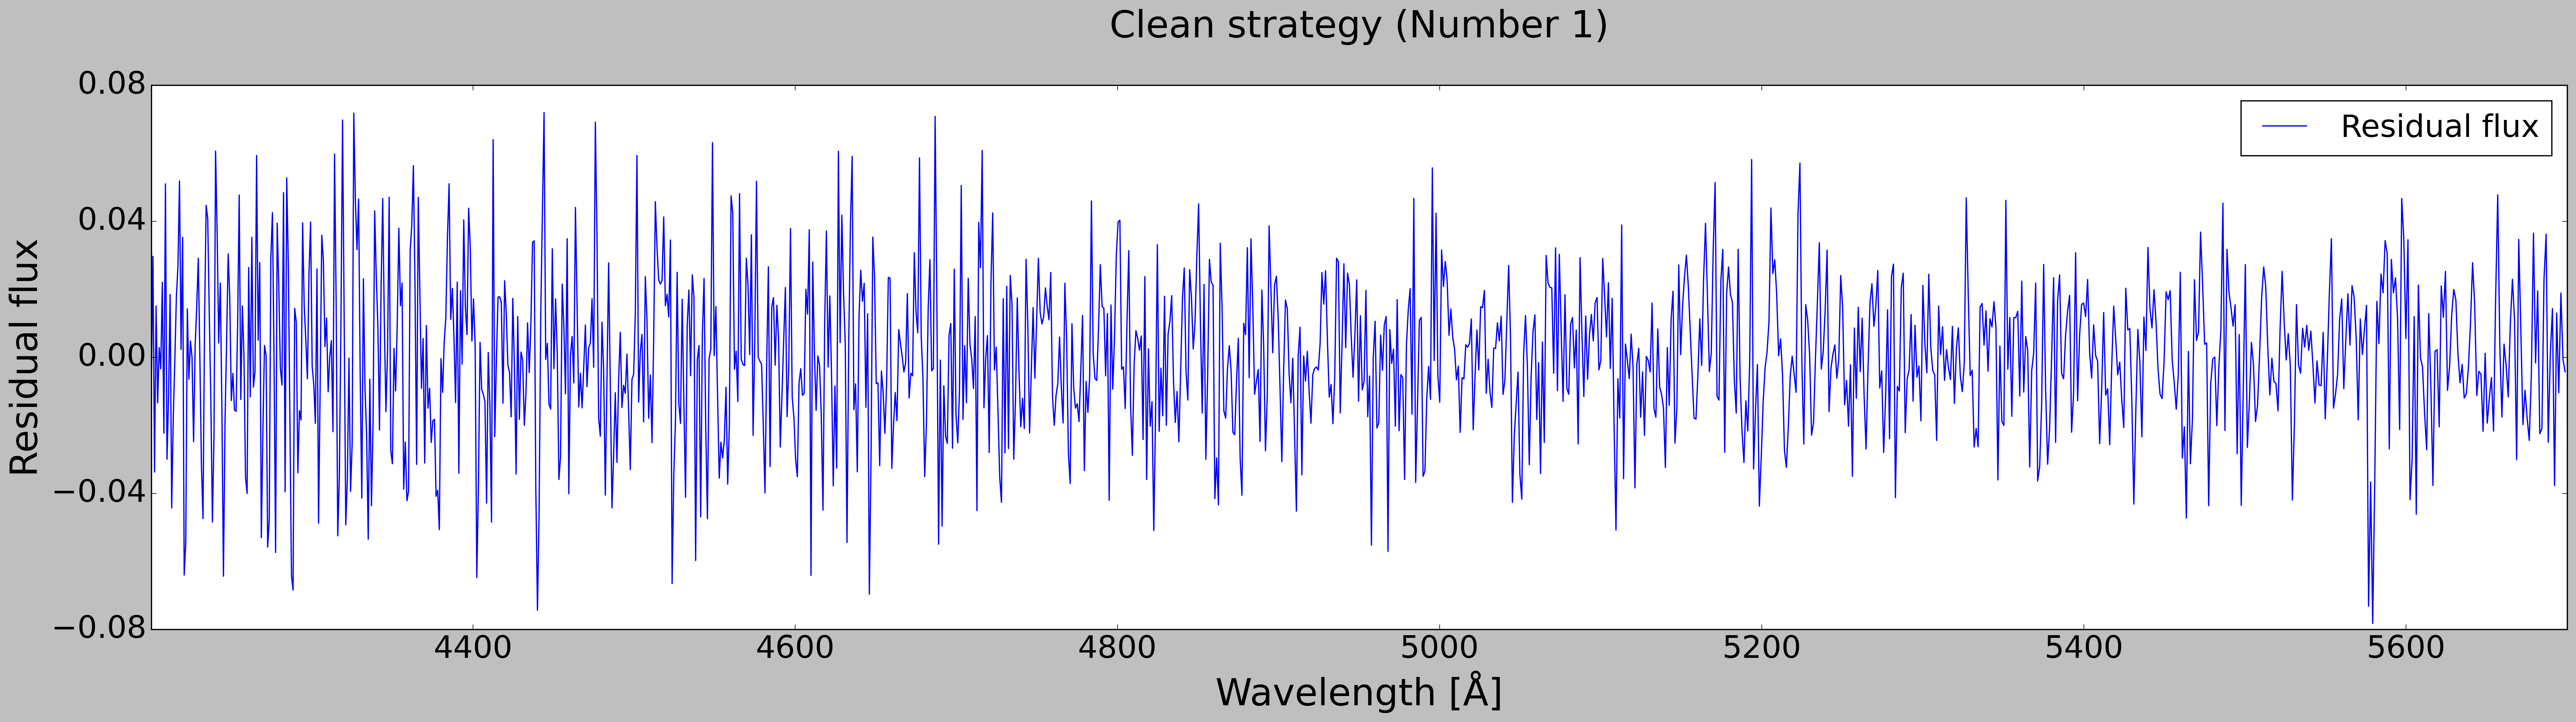

(6). Number of clipped outliers: 1+0+0 out of 1326
--------------------------------------------------------------------
==================== Clean strategy (Number 2) =====================
--------------------------------------------------------------------
3. Inferred stellar atmospheric parameters
--------------------------------------------------------------------
  Parameter  =   BestFit ±   Error
(1). RV      =   -16.56  ±   0.98
(2). RV_s    =    62.18  ±   1.03
(3). Teff    =  4035.30  ±  13.38
(4). log g   =     4.58  ±   0.04
(5). [Fe/H]  =    -0.06  ±   0.02
--------------------------------------------------------------------
--------------------------------------------------------------------
4. Convergence status of the fit
--------------------------------------------------------------------
(1). Number of function evaluations: 2
(2). Final RMS of flux residuals: 0.023211
(3). Fit status flag: 2
(4). Termination message: `ftol` termination condition is satisfied.
(5). Param

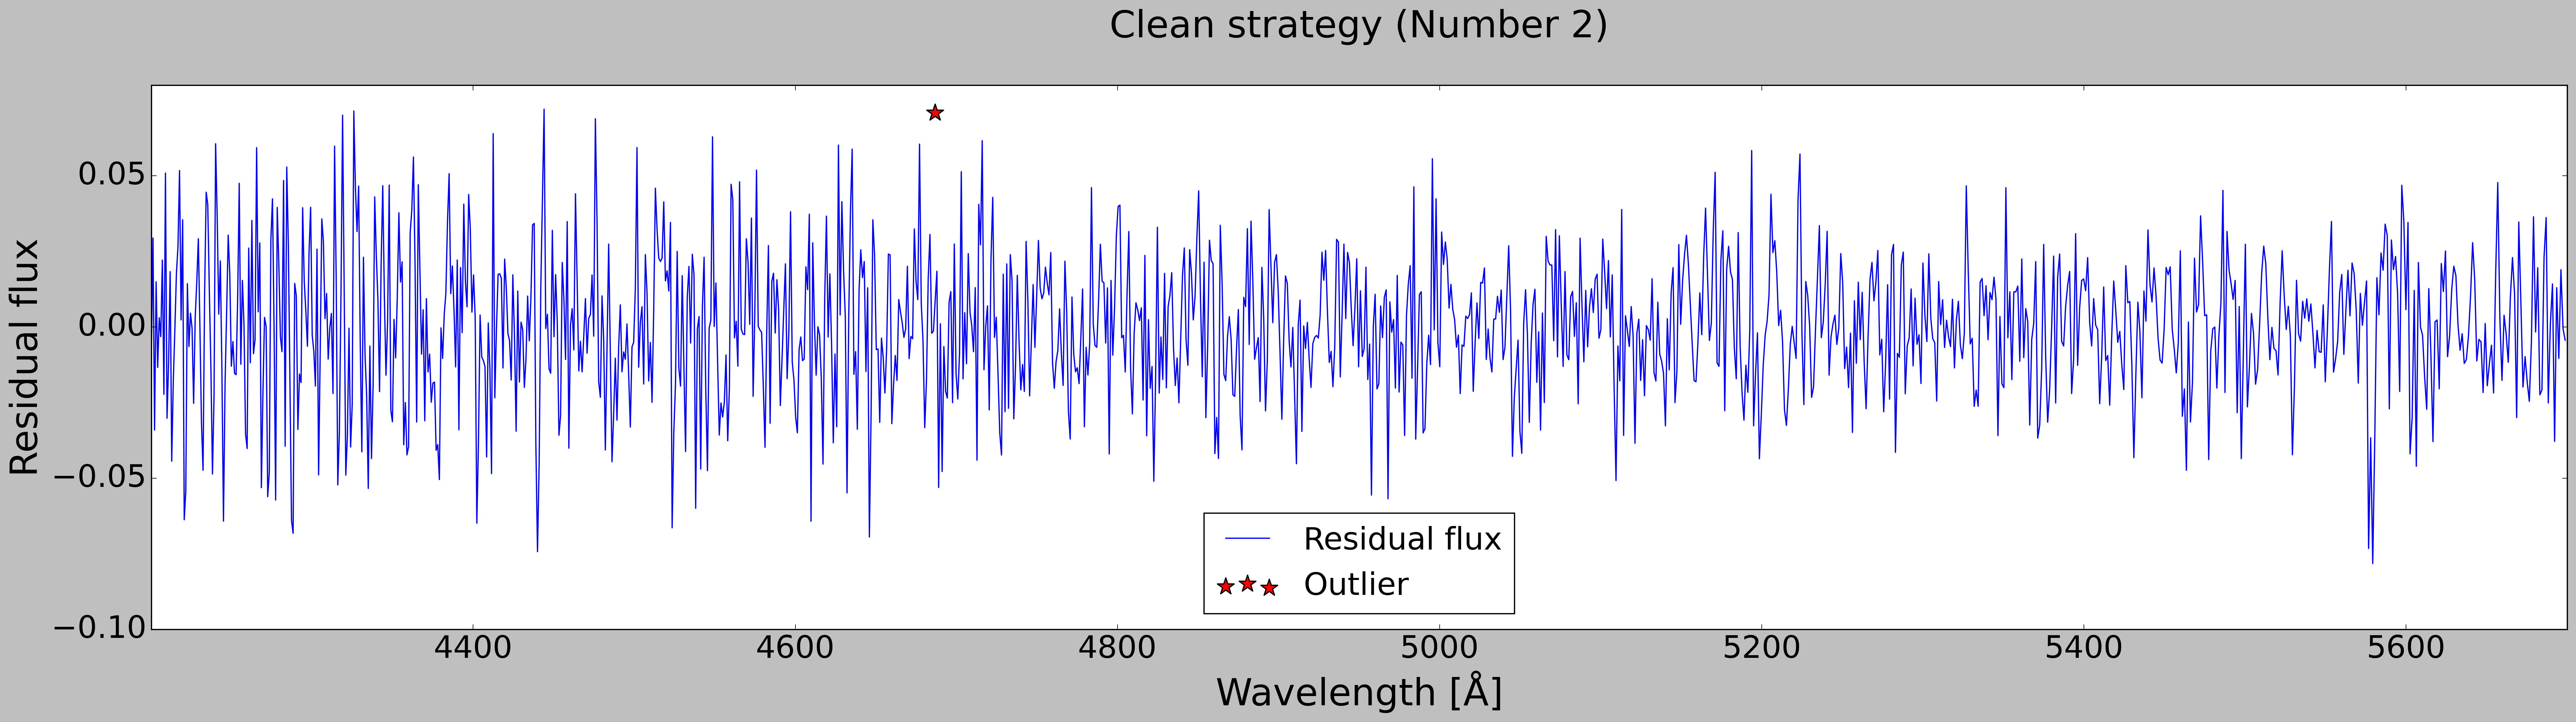

(6). Number of clipped outliers: 1+0+2 out of 1326
--------------------------------------------------------------------
==================== Clean strategy (Number 3) =====================
--------------------------------------------------------------------
3. Inferred stellar atmospheric parameters
--------------------------------------------------------------------
  Parameter  =   BestFit ±   Error
(1). RV      =   -16.47  ±   0.98
(2). RV_s    =    62.20  ±   1.02
(3). Teff    =  4035.69  ±  13.24
(4). log g   =     4.58  ±   0.04
(5). [Fe/H]  =    -0.05  ±   0.02
--------------------------------------------------------------------
--------------------------------------------------------------------
4. Convergence status of the fit
--------------------------------------------------------------------
(1). Number of function evaluations: 2
(2). Final RMS of flux residuals: 0.023068
(3). Fit status flag: 2
(4). Termination message: `ftol` termination condition is satisfied.
(5). Param

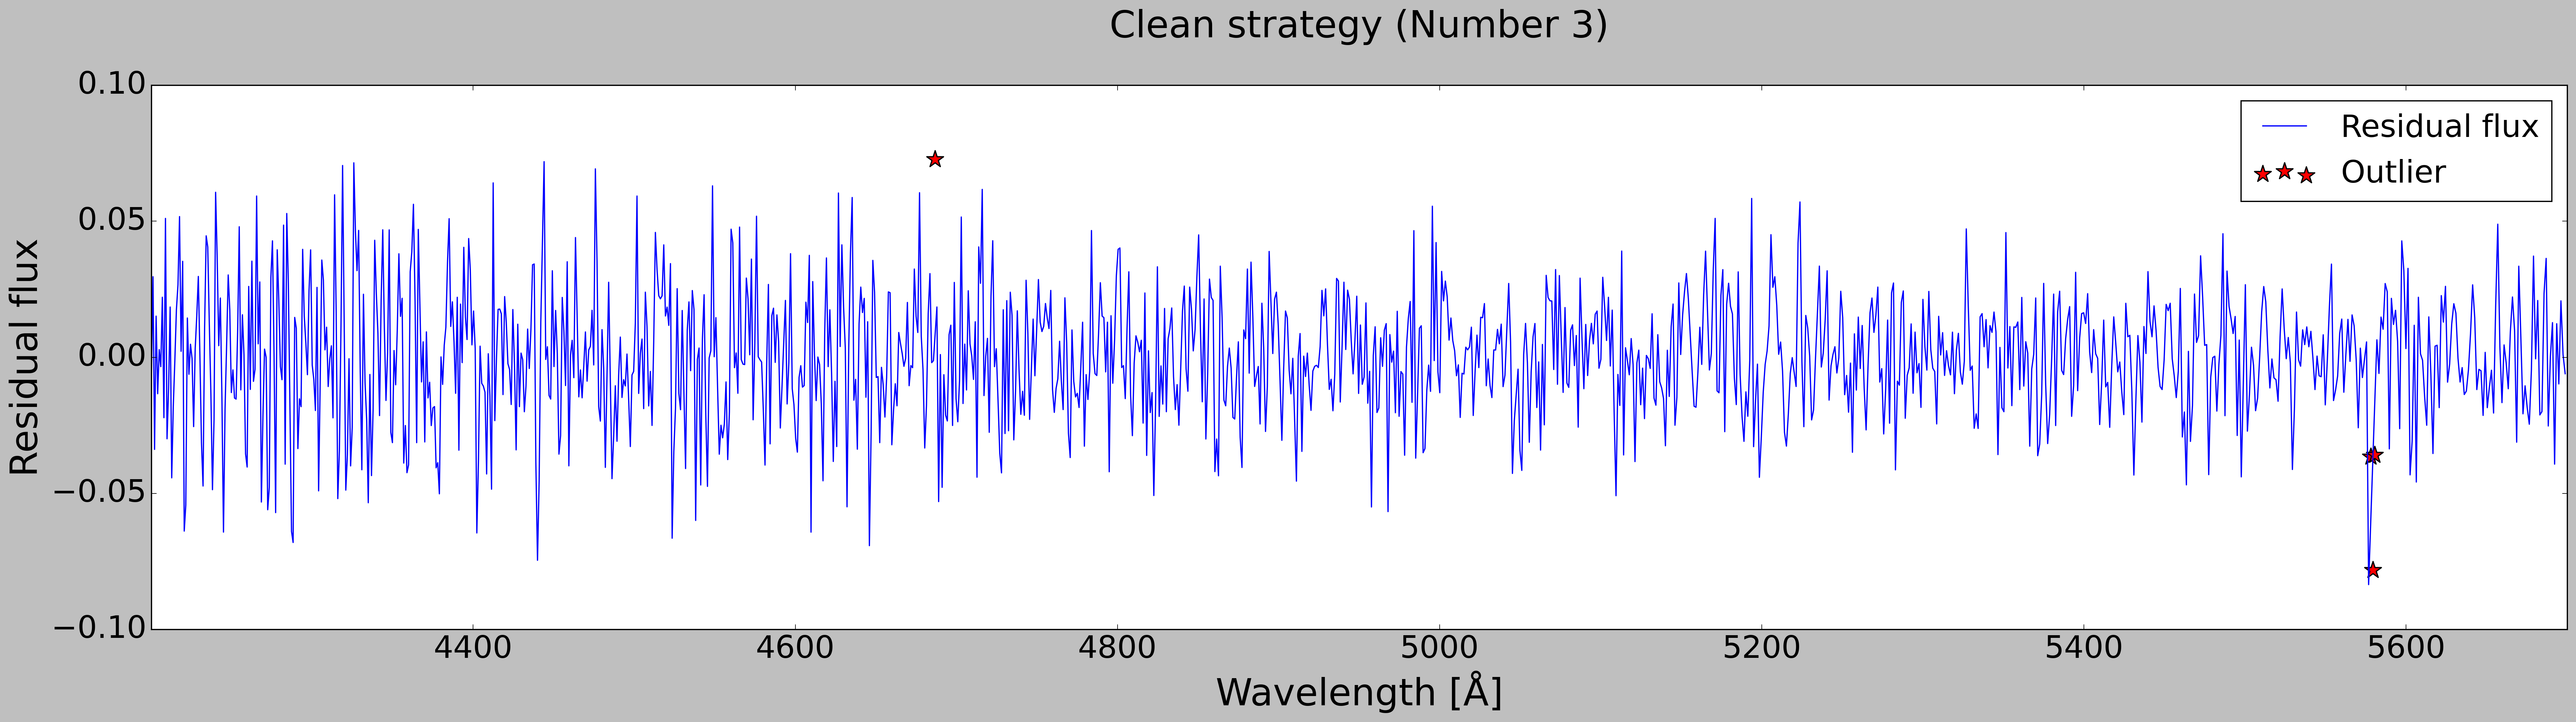

(6). Number of clipped outliers: 1+0+3 out of 1326
--------------------------------------------------------------------
==================== Clean strategy (Number 4) =====================
--------------------------------------------------------------------
3. Inferred stellar atmospheric parameters
--------------------------------------------------------------------
  Parameter  =   BestFit ±   Error
(1). RV      =   -16.54  ±   0.97
(2). RV_s    =    62.19  ±   1.02
(3). Teff    =  4035.74  ±  13.14
(4). log g   =     4.59  ±   0.04
(5). [Fe/H]  =    -0.05  ±   0.02
--------------------------------------------------------------------
--------------------------------------------------------------------
4. Convergence status of the fit
--------------------------------------------------------------------
(1). Number of function evaluations: 2
(2). Final RMS of flux residuals: 0.022953
(3). Fit status flag: 2
(4). Termination message: `ftol` termination condition is satisfied.
(5). Param

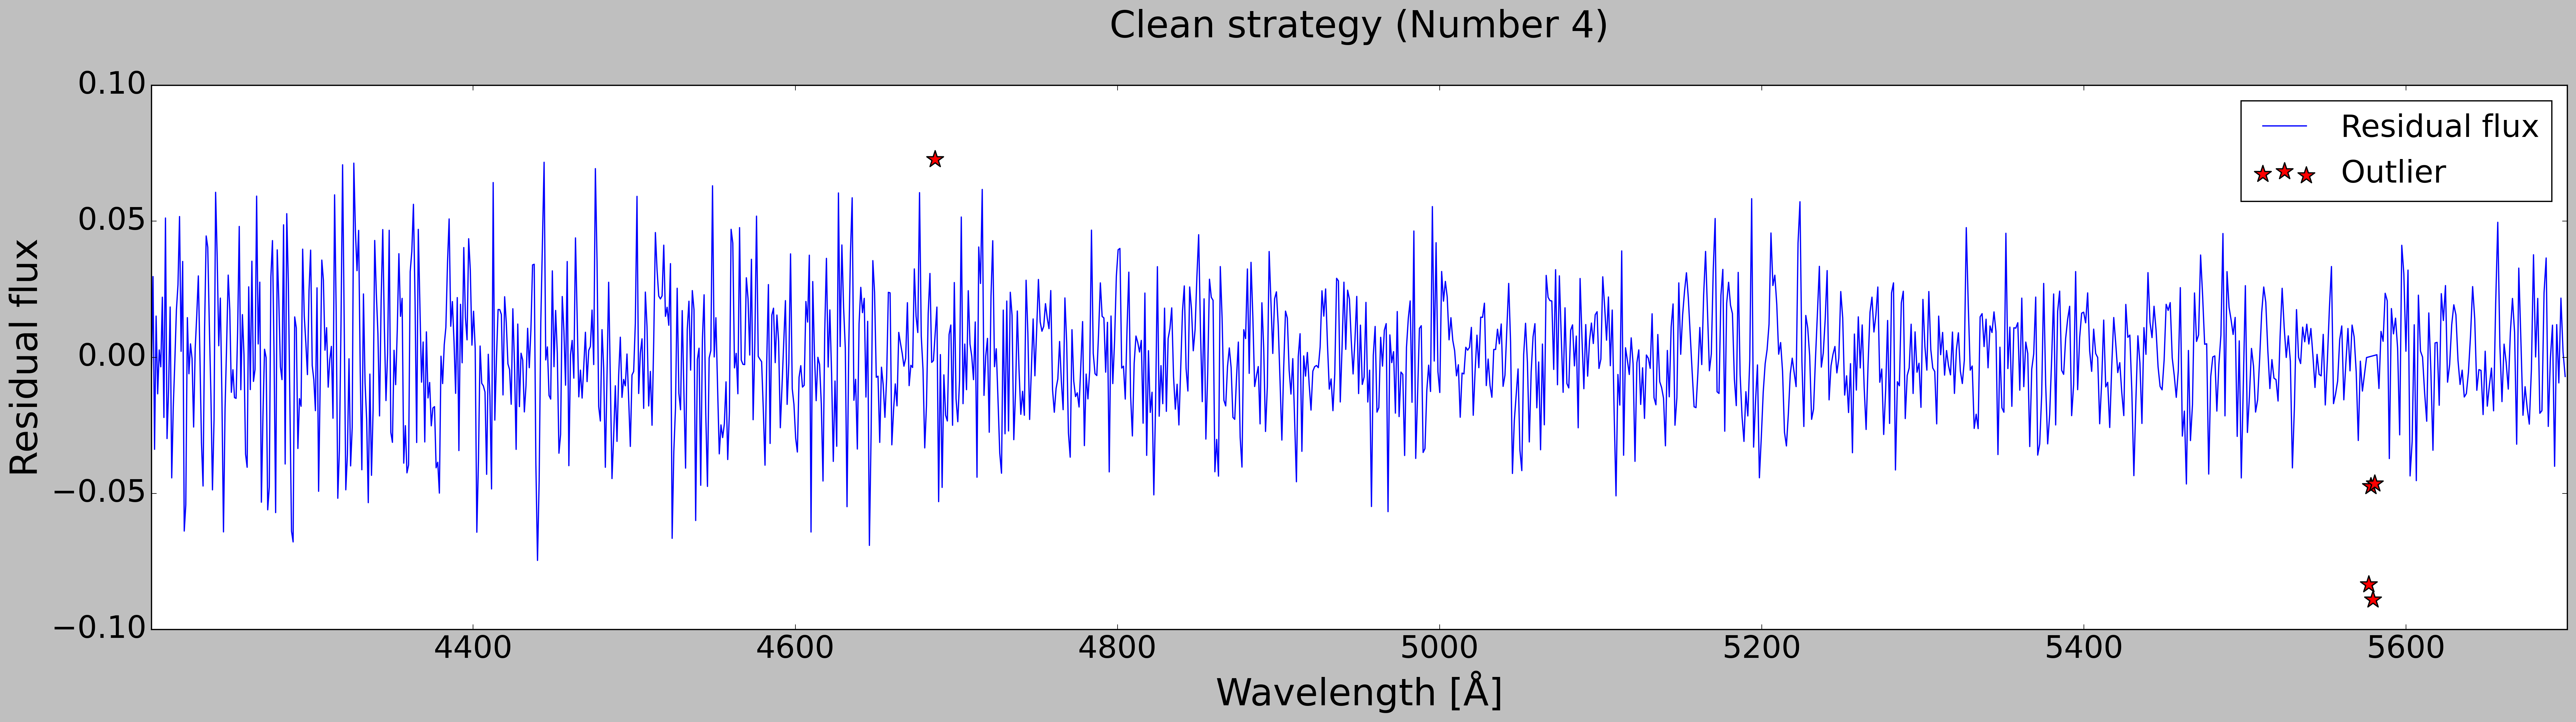

(6). Final number of clipped outliers: 1+0+3 out of 1326
--------------------------------------------------------------------
####################################################################
###################### Elapsed time:  3.87  s ######################
####################################################################
--------------------------------------------------------------------


In [7]:
# Select a spectrum for visualization
example_idx = 0

print(f"Visualizing fit for: {ID[example_idx]}\n")

# Load and fit spectrum with plotting enabled
inspectr = uly_spect_read_lms(
    lmin=[4200],
    lmax=[5700],
    file_in=base_fits_dir + ID[example_idx],
    public=True,
    flux_median=True,
    err_bool=False,
    mask_bool=False,
)

(Rv, Teff, logg, FeH, Rv_err,
 Teff_err, logg_err, FeH_err,
 used_time, loss, clean_number) = ulyss(
    inspectr=inspectr,
    mdegree=50,
    adegree=-1,
    allow_polynomial_reduction=False,
    sampling_function="linear",
    deep_copy=False,
    clean=True,
    quiet=False,  # ⚠️ Prints inference process
    full_output=True,  # ⚠️ Enable diagnostic visualization
    plot_fitting=True,  # ⚠️ Enable diagnostic visualization
    t_guess=7500,
    l_guess=3,
    z_guess=-0.5,
    t_limits=[3100.0, 40000.0],
    l_limits=[-0.25, 5.9],
    z_limits=[-2.5, 1.0],
    model_file=TGM_MODEL_FILE()
)

---

## 4. Use case 3: GPU-accelerated batch inference with LASP-Adam-GPU

For large-scale surveys (>$100{,}000$ spectra), **LASP-Adam-GPU** accelerates processing using GPU-accelerated gradient descent. Key features:

- **Group processing**: Process $N$ spectra simultaneously
- **Automatic differentiation**: PyTorch's autograd for efficient gradients
- **Adam optimizer**: Robust convergence for high-dimensional problems

### 4.1 Load observed spectra

We use the same LAMOST dataset from Tutorial 2.

In [8]:
# Define path to LAMOST spectral data
base_fits_dir = TEST_DATA_DIR() + "LAMOST_spec_fits/"
# Get FITS file inventory
all_fits_names = os.listdir(base_fits_dir)
# PT file storage directory
all_pt = TEST_DATA_DIR() + "LAMOST_spec_pt/"

print(f"LAMOST spectral data for GPU processing:")
print(f"  Directory: {os.path.relpath(base_fits_dir)}")
print(f"  Total spectra: {len(all_fits_names)}")
print(f"  .pt files → {os.path.relpath(all_pt)}")
print(f"  GPU device: {device}")

LAMOST spectral data for GPU processing:
  Directory: test_data\LAMOST_spec_fits
  Total spectra: 25
  .pt files → test_data\LAMOST_spec_pt
  GPU device: cuda


### 4.2 Pre-process and pack spectra into PyTorch tensors

Convert FITS files to optimized `.pt` (PyTorch tensor) format. This pre-processing step:

1. **Reads FITS files** and extracts flux arrays
2. **Pre-computes auxiliary arrays**: wavelength grids, borders, NewBorders, Legendre polynomials
3. **Packs into tensor batches**: Enables efficient GPU memory transfer
4. **Stores metadata**: Spectrum IDs, initial parameter guesses, etc.

This `.pt` file is designed to enable the simultaneous inference of stellar parameters for $N$ spectra in one pass.

In [9]:
# Configure tensor packing
print(f"Converting FITS → PyTorch tensors (.pt format)...\n")

data_to_pt(
    all_spec_fits_names=all_fits_names,  # List of FITS file names
    base_fits_dir=base_fits_dir,  # Directory path containing all FITS files
    model_file=TGM_MODEL_FILE(),  # Emulator coefficients path
    save_pt_file=all_pt,  # Output directory for .pt files
    each_pt_number=np.min([20000, len(all_fits_names)]),  # Max spectra per .pt file
    npix=1327,  # LAMOST spectral pixels
    lmin=[4200],  # Minimum wavelength (Angstrom)
    lmax=[5700],  # Maximum wavelength (Angstrom)
    n_jobs=9,  # CPU cores for parallel I/O
    # Initial parameter guesses (applied uniformly to all spectra)
    ini_Teff=7500.0,
    ini_logg=3.5,
    ini_FeH=-0.5,
    ini_mu=0.0,
    ini_sigma=1.0,
)

print(f"\n✓ Spectra successfully packed into .pt format")
print(f"  .pt files → {os.path.relpath(all_pt)}")

Converting FITS → PyTorch tensors (.pt format)...



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Elapsed time:  0.00104 h!

✓ Spectra successfully packed into .pt format
  .pt files → test_data\LAMOST_spec_pt


### 4.3 Inspect packed data structure

Verify the tensor format before GPU processing.

In [10]:
# List generated .pt files
all_pt_address = os.listdir(all_pt)

# Load first file for inspection
pt_0 = torch.load(
    all_pt + all_pt_address[0],
    weights_only=False
)

# Extract tensor fields
(
    all_wavelength,    # Wavelength array (Å)
    all_borders,       # Model wavelength bin edges
    all_NewBorders,    # LAMOST resampled wavelength bin edges
    flat,              # Flat-field correction vector
    spec_coef,         # Emulator coefficients
    leg_array,         # Legendre polynomial basis
    all_spectra_data,  # Observed flux tensors
    all_ini_params,    # Initial guesses [N_spectra × 5]
    all_ID,            # Spectrum identifiers
) = (
    pt_0["wavelength_data"],
    pt_0["borders"],
    pt_0["NewBorders"],
    pt_0["flat"],
    pt_0["spec_coef"],
    pt_0["leg_array"],
    pt_0["spectra_data"],
    pt_0["ini_params"],
    pt_0["ID"],
)

# Display tensor structure
print(f"\n{'='*70}")
print(f".pt files → {os.path.relpath(all_pt)}")
print(f"PyTorch tensor structure: {all_pt_address[0]}")
print(f"{'='*70}")
print(f"Total .pt files: {len(all_pt_address)}")
print(f"\nTensor dimensions:")
print(f"  Observed spectra: {all_spectra_data.shape}  [N_spec × N_pix]")
print(f"  Wavelength grid: {all_wavelength.shape}")
print(f"  Emulator coefficients: {spec_coef.shape}  [N_term × N_pix × N_regime]")
print(f"  Legendre basis: {leg_array.shape}  [N_pix × N_poly]")
print(f"  Initial parameters: {all_ini_params.shape}  [N_spec × 5]")
print(f"    Columns: [Teff, log g, [Fe/H], mu, sigma]")
print(f"\nWavelength coverage: {all_wavelength[0]:.2f} - {all_wavelength[-1]:.2f} Å")
print(f"\nSpectrum IDs (first 5):")
for i in range(min(5, len(all_ID))):
    print(f"  [{i+1}] {all_ID[i][0]}")
print(f"{'='*70}")


.pt files → test_data\LAMOST_spec_pt
PyTorch tensor structure: 0.pt
Total .pt files: 1

Tensor dimensions:
  Observed spectra: torch.Size([25, 1327])  [N_spec × N_pix]
  Wavelength grid: torch.Size([1327])
  Emulator coefficients: torch.Size([23, 7506, 3])  [N_term × N_pix × N_regime]
  Legendre basis: torch.Size([1327, 51])  [N_pix × N_poly]
  Initial parameters: torch.Size([25, 5])  [N_spec × 5]
    Columns: [Teff, log g, [Fe/H], mu, sigma]

Wavelength coverage: 4200.28 - 5700.05 Å

Spectrum IDs (first 5):
  [1] 3703110.fits
  [2] 3706009.fits
  [3] 3706011.fits
  [4] 3706103.fits
  [5] 3706125.fits


### 4.4 Initialize output file

Create CSV file for LASP-Adam-GPU results.

In [11]:
# Define output file path
save_LASP_Adam_params_csv_file = (
    TEST_DATA_DIR() + "PyLASP_inferred_results/LASP_Adam_inferred.csv"
)

# Define output schema
output_columns_adam = [
    "ID",
    "pred_Rv",
    "pred_Teff",
    "pred_logg",
    "pred_FeH",
    "pred_Rv_err",
    "pred_Teff_err",
    "pred_logg_err",
    "pred_FeH_err",
    "use_time",
    "total_loss",
    "alone_loss",
    "iter",
]

# Initialize DataFrame
LASP_Adam_inferred_params_csv = pd.DataFrame(columns=output_columns_adam)

# Create output file
LASP_Adam_inferred_params_csv.to_csv(save_LASP_Adam_params_csv_file, index=False)

print(f"✓ Output file initialized")
print(f"  Path: {os.path.relpath(save_LASP_Adam_params_csv_file)}")

✓ Output file initialized
  Path: test_data\PyLASP_inferred_results\LASP_Adam_inferred.csv


### 4.5 Run GPU-accelerated inference

Execute LASP-Adam-GPU on all `.pt` files. The optimization workflow:

1. **Load batch to GPU**: Transfer spectra and auxiliary arrays
2. **Normalize parameters**: Scale to standard range for stable gradients
3. **Forward pass**: Generate spectrum → wavelength resampling → resolution degradation → correcting shape differences
4. **Loss computation**: Flux residuals with optional outlier masking
5. **Backpropagation**: Compute gradients via PyTorch autograd
6. **Parameter update**: Adam step with learning rate 0.1
7. **Convergence check**: Stop when Δloss < 10⁻⁵ for 50 consecutive iterations or no improvement for 50 steps
8. **Uncertainty estimation**: Finite-difference Jacobian

In [12]:
# Configure batch processing parameters
batch_size = 10000  # Adjust based on GPU memory
max_iterations = 5000  # Maximum Adam iterations per batch
enable_clean = True  # Enable outlier rejection (recommended)

print(f"Starting LASP-Adam-GPU inference:")
print(f"  .pt files → {os.path.relpath(all_pt)}")
print(f"  Number of .pt files: {len(all_pt_address)}")
print(f"  Batch size: {batch_size}")
print(f"  Max iterations: {max_iterations}")
print(f"  Outlier rejection: {'enabled' if enable_clean else 'disabled'}")
print(f"  GPU device: {device}\n")

# Process all .pt files sequentially
for i, pt_i_address in enumerate(all_pt_address):

    print(f"[{i+1}/{len(all_pt_address)}] Processing: {os.path.relpath(pt_i_address)}")

    # Run LASP-Adam-GPU
    uly_fit_conv_poly(
        pt_file=all_pt + pt_i_address,  # Path to .pt file
        group_size=batch_size,  # Batch size (spectra per group)
        max_inter=max_iterations,  # Maximum Adam iterations
        clean=enable_clean,  # Enable outlier rejection
        save_params_csv_file=save_LASP_Adam_params_csv_file,  # Output CSV path
        quiet=True, # Don't print some inference process when clean=True
    )

print(f"\n{'='*70}")
print("✓ All .pt files processed successfully")
print(f"Saved: {os.path.relpath(save_LASP_Adam_params_csv_file)}")
print(f"{'='*70}")

# Load and analyze results
results = pd.read_csv(save_LASP_Adam_params_csv_file)

print(f"\nFirst 10 results:")
print(results[["ID", "pred_Teff", "pred_logg", "pred_FeH", "alone_loss", "iter"]].head(10))

Starting LASP-Adam-GPU inference:
  .pt files → test_data\LAMOST_spec_pt
  Number of .pt files: 1
  Batch size: 10000
  Max iterations: 5000
  Outlier rejection: enabled
  GPU device: cuda

[1/1] Processing: 0.pt
Processing test_data\LAMOST_spec_pt\0.pt, total 25 samples! Inferring samples 0-25 completed in: 10.14 seconds!

✓ All .pt files processed successfully
Saved: test_data\PyLASP_inferred_results\LASP_Adam_inferred.csv

First 10 results:
             ID  pred_Teff  pred_logg  pred_FeH  alone_loss  iter
0  3703110.fits  4034.2847   4.588619 -0.044177    0.034776   200
1  3706009.fits  5904.1484   4.164043 -0.294331    0.030931   200
2  3706011.fits  6241.0967   4.445561 -0.472303    0.035609   200
3  3706103.fits  4905.4604   3.213287 -0.394971    0.040522   200
4  3706125.fits  5544.7983   4.639184 -0.297733    0.027198   200
5  3709013.fits  5791.0530   4.288022 -0.310617    0.046087   200
6  3709130.fits  5503.4365   4.569391 -0.190533    0.044125   200
7  3709131.fits  5577.23

---

## Notes

- When applying `PyLASP` to other surveys, customize `uly_spect_read_lss` and `uly_spect_read_lms` to accommodate survey-specific `.fits` formats.
- If initial guesses for $T_{\rm eff}$, log $g$, and [Fe/H] are available, provide them in `data_to_pt.py` for better convergence with `LASP-Adam-GPU`.
- `LASP-Adam-GPU` results may vary slightly between GPU runs due to non-deterministic operations in parallel computation and floating-point precision.